# Moisture Sorption Analysis

> [Return to Examples List](README.md)

This notebook demonstrates how to perform an analysis of sorption analysis performed on a wood sample.

## Load Experiment Data

First, let's load the experiment data from a JSON file and convert it into a Pandas `DataFrame`.

In [1]:
# This is just to ensure you have the data file, downloaded from TA's website
from file_downloader import download_files

filename = "SA - Wood.json"
file_path = download_files(filename, "files/")[0]

In [2]:
from tadatakit.classes import Experiment

# Load the experiment data
experiment = Experiment.from_json(file_path)
step_names, dfs = experiment.get_dataframes_by_step("processed")

## Identifying Procedure Steps

We can look at `step_names` to see which step we want to analyse, this is also accessible at `experiment.procedure.steps`.

In [3]:
for idx, step_name in enumerate(step_names):
    print(f"{idx}\t{step_name}")

0	Sample Interval  10.0 s/pt
1	Equilibrate 25.00 °C
2	Set Humidity 0 %RH  
3	Isothermal 1440.0 min
4	Step Humidity 10.0000 %RH for 600 min to 75.0000 %RH,  Abort humidity step if % weight change < 0.0200 % for 10 min
5	Set Humidity 80 %RH  
6	Isothermal 10080.0 min
7	Dry sample 60.00 °C for 360.00 min
8	Set Humidity 0 %RH  
9	Equilibrate 25.00 °C
10	Isothermal 120.0 min


## Plot Sorption Isotherms

First we can investigate hygrophobicity by plotthing the weight against relative humidity from the "Step Humidity 10.0000 %RH for 600 min to 75.0000 %RH,  Abort humidity step if % weight change < 0.0200 % for 10 min" step, and calculating the slope.

Hygroscopicity coefficient: 0.16


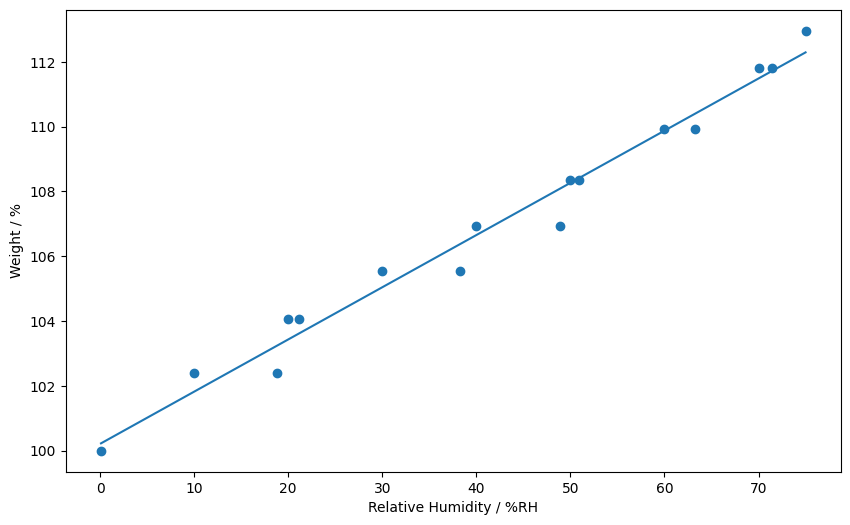

In [4]:
# Set up linear regression function
import numpy as np

def linear_regression(x, y):  
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    m = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    c = y_mean - m * x_mean
    return m, c

# Select the step and establish equilibrium points at each humidity
step_df = dfs[4]
equilibrium_points = step_df.groupby('Relative Humidity / %RH').last().reset_index()
m, c = linear_regression(equilibrium_points['Relative Humidity / %RH'], equilibrium_points['Weight / %'])
# print(m, c)

# Generate plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    equilibrium_points["Relative Humidity / %RH"],
    equilibrium_points["Weight / %"],
)
x_values = np.array([equilibrium_points['Relative Humidity / %RH'].min(), equilibrium_points['Relative Humidity / %RH'].max()])
y_values = m * x_values + c
plt.plot(x_values, y_values)

plt.xlabel("Relative Humidity / %RH")
plt.ylabel("Weight / %")
print(f"Hygroscopicity coefficient: {m:.2f}")
plt.show()

## Fitting the Brunauer-Emmett-Teller (BET) Equation

Next we can plot a form of the BET equation, $(\text{RH} \cdot \text{MW}) / (0.01 \cdot \Delta \text{Wt\%} \cdot (100 - \text{RH}))$, against relative humidity to establish slope and intercepts we can use to estimate surface area.

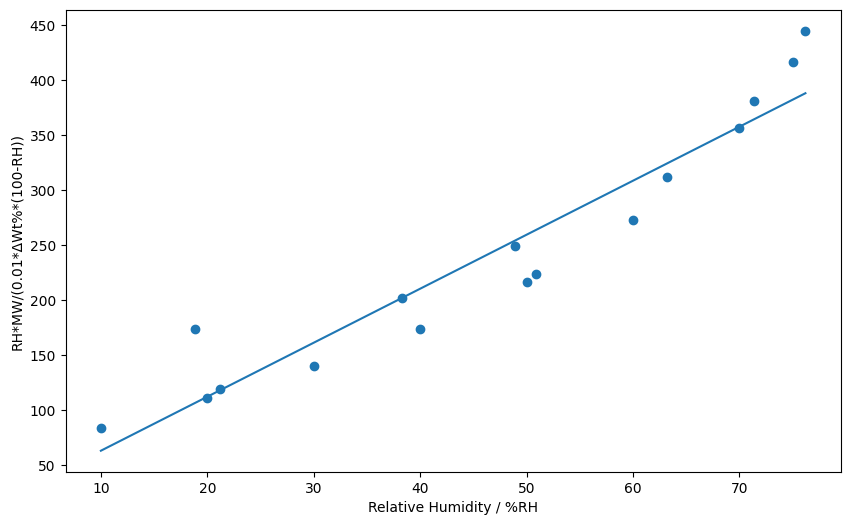

In [5]:
# Get the data where TRIOS calculated RH/(0.01*ΔWt%*(100-RH))
bet_df = experiment.get_dataframe("processed").dropna(subset='RH/(0.01*ΔWt%*(100-RH))')
molecular_weight_water = 18.0153
bet_df['RH*MW/(0.01*ΔWt%*(100-RH))'] = bet_df['RH/(0.01*ΔWt%*(100-RH))'] * molecular_weight_water

# Separate out data below 50% RH and perform linear regression
bet_fit_df = bet_df[bet_df['Relative Humidity / %RH']<50]
bet_m, bet_c = linear_regression(bet_df['Relative Humidity / %RH']/100, bet_df['RH*MW/(0.01*ΔWt%*(100-RH))'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(
    bet_df["Relative Humidity / %RH"],
    bet_df["RH*MW/(0.01*ΔWt%*(100-RH))"],
)
y = bet_m*bet_df['Relative Humidity / %RH']/100 + bet_c
plt.plot(
    bet_df['Relative Humidity / %RH'],
    y,
)

plt.xlabel("Relative Humidity / %RH")
plt.ylabel("RH*MW/(0.01*ΔWt%*(100-RH))")
plt.show()

## Estimating Surface Area

We can use those results to estimate a variety of properties of this sample.

In [6]:
Wm = 1/(bet_m + bet_c)
C = bet_m/bet_c + 1 
R = 8.3144598
T = bet_df['Temperature / °C'].mean()
Qn = R * T * np.log(C)
N = 6.0221e23
Am = 12.5e-20
SA = Wm * N * Am
print(f"Monolayer capacity: {Wm:.2E} mol/g\nBET Constant C: {C:.1f}\nHeat of Adsorption: {Qn:.1f} J/g\nSurface Area: {SA:.1f} m²/g")

Monolayer capacity: 1.98E-03 mol/g
BET Constant C: 37.1
Heat of Adsorption: 751.2 J/g
Surface Area: 149.0 m²/g


For more information, check out [TA-362](https://www.tainstruments.com/applications-notes/bet-analysis-of-the-adsorption-of-water-on-microcrystalline-cellulose/).